In [ ]:
!pip install datasets
#!pip install transformers
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 878.5 kB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset
import json
dataset = load_dataset("gsm8k", 'main')

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
def clean_data(text):
  return text.replace("<<", "").replace(">>", "")

dataset = dataset.map(lambda x: {"answer": clean_data(x["answer"])})

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
train_dataset = dataset["train"].with_format("torch")
train_dataset = train_dataset.shuffle(seed=42)
dev_dataset = train_dataset.select(range(0,1000))
train_dataset = train_dataset.select(range(1000, len(train_dataset)))

debug_dataset = train_dataset.select(range(0,5))
test_dataset = dataset["test"].with_format("torch")

In [ ]:
print(train_dataset[837]["question"])

Three cats sat on a fence, meowing at the moon.  The first cat meowed 3 times per minute.  The second cat meowed twice as frequently as the first cat.  And the third cat meowed at one-third the frequency of the second cat.  What is the combined total number of meows the three cats make in 5 minutes?


In [ ]:
print(train_dataset[837]["answer"])

The second cat meowed twice as frequently as the three meows per minute from the first cat, for a total of 2*3=2*3=66 meows per minute.
The third cat meowed at one-third the frequency of the second cat, for a total of 6/3=6/3=22 meows per minute.
Thus, combined, the three cats meow 3+6+2=3+6+2=1111 times per minute.
In five minutes, the three cats meow 5*11=5*11=5555 times.
#### 55


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False)
debug_dataloader = DataLoader(debug_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-1_5:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [ ]:
!pip install flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 33.1 MB/s eta 0:00:00
  Created wheel for flash-attn: filename=flash_attn-2.3.6-cp310-cp310-linux_x86_64.whl size=56598219 sha256=07a5c68948f0dbdc00e4ca74e7247ceb0c4adcde7f29d3de358c8ac2b8848709
  Stored in directory: /root/.cache/pip/wheels/24/5f/16/5044cdddb6dfb3331dfbffa28ab6096ec2900777af5cb0253a
Successfully built flash-attn


In [ ]:
chain_of_thought_prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in
total he has 7 + 2 = 9 toys. The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20
computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The
answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday
he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in beginning,
so now she has $23 - $15 = $8. The answer is 8""" # 8-shot prompt from pg. 43 in the CoT paper

non_chain_of_thought_prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A: The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room?
A: The answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday?
A: The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: The answer is 8"""

test_prompt = "test" # for easier visibility when debugging

In [ ]:
chain_of_thought_prompt = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The answer is #6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is #5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is #39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is #8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in
total he has 7 + 2 = 9 toys. The answer is #9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20
computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The
answer is #29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday
he lost 2 more so now he has 35 - 2 = 33 balls. The answer is #33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in beginning,
so now she has $23 - $15 = $8. The answer is #8""" # 8-shot prompt from pg. 43 in the CoT paper. I manually added # before the final answer.

In [ ]:
QAP_COT_Combination = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today? Explain this problem to me in at least 50 words. Then solve for the answer.
A: Originally, there were 15 trees in the grove. The grove workers planted an unknown amount of trees in the grove. Currently,
there are 21 trees in the grove. We need to find out how many trees the grover workers had planted. We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The answer is 6.

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot? Explain this problem to me in at least 50 words. Then solve for the answer.
A: To begin, there were 3 cars in the parking lot. Later, 2 more cars arrive at the parking lot. We need to solve for the total amount of cars there
currently is. There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total? Explain this problem to me in at least 50 words. Then solve for the answer.
A: Leah had originally 32 chocolates. Her sister had 42 chocolates. We need to find out how many pieces of chocolate they have left after eating 35 chocolates. Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.

Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny? Explain this problem to me in at least 50 words. Then solve for the answer.
A: Jason originally had 20 lollipops. After giving Denny a certain amount of lollipops, Jason currently has 12 lollipops. We need to calculate how many lollipops
Jason gave to Denny. Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.

Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now? Explain this problem to me in at least 50 words. Then solve for the answer.
A: Shawn originally had 5 toys. Both his mom and dad each gave him 2 toys. We need to find out total toys he now has. He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in
total he has 7 + 2 = 9 toys. The answer is 9.

Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room? Explain this problem to me in at least 50 words. Then solve for the answer.
A: Originally, there were 9 computers in the server room. On each day, from Monday through Thursday, 5 more computers were installed. We need to find out
how many total computers there currently is in the server room. There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20
computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The
answer is 29.

Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday? Explain this problem to me in at least 50 words. Then solve for the answer.
A: To start, Michael had 58 golf balls. He then lost 23 golf balls on Tuesday. On Wednesday, he further lost 2 more golf balls. We need to find out how
many golf balls he has remaining. Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday
he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.

Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left? Explain this problem to me in at least 50 words. Then solve for the answer.
A: Olivia started off with $23. She then bought 5 bagels which costed $3 per bagel. We need to find out how much money she has remaining. She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in beginning,
so now she has $23 - $15 = $8. The answer is 8"""

In [ ]:
error_analysis = """Q: In a classroom, there are 5 rows of desks, and each row has 7 desks. How many desks are there in total?
A: There are 5 rows of desks, and each row has 7 desks. So in total, there are 5 * 7 = 40 desks. The answer is 40.
R: The error in this answer is that 5 * 7 = 35, not 40. Therefore, the answer is incorrect and the correct answer is 35.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 10 lollipops. The answer is 10.
R: The error in this answer is in the equation 20 - 12 = 10. 20 - 12 does not equal 10, it equals 8. Therefore, 10 is incorrect
and the correct answer is 8.
Q: Michael had 58 golf balls. On Tuesday, he lost 23 golf balls. On Wednesday, he lost 2 more. How many golf
balls did he have at the end of Wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday
he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.
R: 58 - 23 = 35, and 35 - 2 = 33. There are no errors in this answer, and the correct answer is 33.
Q: Horace is selling his old comic books. He sold 12 comic books on the first week, and 50% more comic books on the second week. How many comic books did he sell in total?
A: Horace sold 12 comic books on the first week. He sold 50% more on the second week. 0.5 * 12 = 6. So he sold 6 + 12 = 18 comic books in total. The answer is 18.
R: The error in this answer is that Horace sold 50% more, not 50% less. This means that the equation should be 1.5 * 12, which equals 18. 12 + 18 = 30. The correct answer is 10. """

In [ ]:
error_analysis_QAPmodified = """Q: In a classroom, there are 5 rows of desks, and each row has 7 desks. How many desks are there in total? Explain this problem to me in at least 50 words. Then solve for the answer.
A: In this problem, there is a classroom which consists of 5 rows of desks. There are 7 desks per row. We need to find out how many total desks there are in the classroom. To solve this problem, we figure out that there are 5 rows of desks, and each row has 7 desks. So in total, there are 5 * 7 = 40 desks. The answer is #40.
R: The error in this answer is that 5 * 7 = 35, not 40. Therefore, the answer is incorrect and the correct answer is 35.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny? Explain this problem to me in at least 50 words. Then solve for the answer.
A: In this problem, Jason originally has 20 lollipops. However, he gives a certain amount of lollipops to Denny. As a result, he now has 12 lollipops.
We need to find out how many lollipops Denny gives to Jason. To solve this problem, we note that Denny now has 12 lollipops. Jason has 20 lollipops. Unfortunately, we do not have enough information to solve this problem.
R: The error in this answer is that the question is asking how many lollipops Jason gives to Denny and not how many lollipops Denny gives to Jason. Since that is the wrong interpretation of the question, it seems as if there is a lack of information available. The correct answer is 20 - 12 = 8 lollipops given to Denny.
Q: Michael had 58 golf balls. On Tuesday, he lost 23 golf balls. On Wednesday, he lost 2 more. How many golf
balls did he have at the end of Wednesday? Explain this problem to me in at least 50 words. Then solve for the answer.
A: In this problem, Michael begins with 58 golf balls. On Tuesday, he loses 23 golf balls. On Wednesday, he further loses 2 more golf balls. The task is to find how many remaining golf balls Michael now has.
To solve this problem, we subtract how many balls he loses from the amount he previously had. 58 - 23 = 35. He loses 2 more balls. 35 + 2 = 37. The correct answer is #37 golf balls.
R: The error in this answer is that 35 + 2 = 37 is the wrong calculation. Michael loses 2 balls, which means you should subtract, not add. 35 - 2 = 33. The correct answer is 33 golf balls.
Q: Horace is selling his old comic books. He sold 12 comic books on the first week, and 50% more comic books on the second week. How many comic books did he sell in total? Explain this problem to me in at least 50 words. Then solve for the answer.
A: In this problem, Horace is selling comic books. In the first week, he sells 12 books. In the second week, he sells 50% more books than the first week. We need to find out
how many comic books Horace sold in total. To solve this problem, we note that Horace sold 12 comic books on the first week. He sold 50% more on the second week. 0.5 * 12 = 6. So he sold 6 + 12 = 18 comic books in total. The answer is #18.
R: The error in this answer is that Horace sold 50% more, not 50% less. This means that the equation should be 1.5 * 12, which equals 18. 12 + 18 = 30. The correct answer is 10.
Q: A city has 300 skyscrapers. 40% of the skyscrapers were destroyed. 50% more skyscrapers were built. How many skyscrapers are now in the city?
A: In this problem, a city has 300 skyscrapers. The city loses 40% of its skyscrapers. However, it gains 50% more skyscrapers than it currently has. We need to find out how many skyscrapers remain. To solve this problem, we calculate 0.4 * 300 = 120. 300 + 120 = 420. However, they gained 50% more skyscrapers. 1.5 * 300 = 450.
In total, the am

In [ ]:
conceptual_error_prompt_modified = [
    {"role": "user", "content": "Q: Jamie has 10 apples. His friend, Horace, has 1/5 fewer apples than Jamie. If they decide to combine their apples and split them evenly, how many apples will Horace have?"},
    {"role": "assistant", "content": "A: Jamie has 5 apples. Horace has 1/5 fewer apples than Jamie, which means he has 1 - 1/5 = 4/5 the amount of apples that Jamie has. To find out how many apples Horace has, we multiply 10 * 4/5 = 8 apples. Therefore, Horace has 8 apples.\nR: This question is asking for the number of apples Horace will have after combining his apples with Jamie's and splitting them evenly. However, this answer only gives the number of apples Horace has before combining his apples with Jamie's. To get the correct answer, we need to add the number of apples Jamie has to the number of apples Horace has, which is 8 + 10 = 18 apples. Then, we divide the apples among both people, so each person gets 18 / 2 = 9 apples. There was a conceptual error and the correct answer is 9 apples."},
    {"role": "user", "content": "Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?"},
    {"role": "assistant", "content": "A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.\nR: This question is asking for the number of lollipops Jason gave to Denny, given that Jason had 20 lollipops and now has 12 lollipops. The answer successfully calculate the number of lollipops Jason gave to Denny through subtraction. There is no error and the correct answer is 8 lollipops."},
    {"role": "user", "content": "Q: Trevor is trying to beat his friend's high score in push ups. He knows that his friend used 42 calories while doing push ups. If each push up requires 3 calories, how many push ups does Trevor need to do to beat his friend's high score?"},
    {"role": "assistant", "content": "A: Trevor's friend used 42 calories while doing push ups. Each push up requires 3 calories, so Trevor needs to do 42 / 3 = 14 push ups to beat his friend's high score. The answer is 14.\nR: This question is asking for the minimum number of push ups Trevor needs to do to beat his friend's high score. While the calculation is correct, this answer does not account for the fact that Trevor needs to beat his friend's high score. To beat the high score, Trevor needs to do 1 more push up than his friend. There was a conceptual error and the correct answer is 15 push ups."},
    {"role": "user", "content": "Q: Every year, Jack gets the same amount of candles as his age on each birthday, which he saves in a candle jar. If Jack is 10 years old, how many candles will he have in total?"},
    {"role": "assistant", "content": "A: Jack will have 10 candles when he is 10 years old. The answer is 10.\nR: This question is asking for the number of candles Jack has in total over the years. However, this answer only gives the number of candles Jack will receive when he is 10 years old, not how many he has in total. To get the correct answer, we need to add the number of candles Jack has received from all his previous birthdays. Since Jack is 10 years old, that means he has gone through 10 birthdays. If Jack gets an equal amount of candles as his birthday age, that means he has 1 + 2 + 3 + 4 + 5 + 6 + 7 + 8 + 9 + 10 = 55 candles There was a conceptual error and the correct answer is 55 candles."},
    {"role": "user", "content": "Q: Katelyn is driving to her friend's house. Her friend is 10 miles away from her house. She also needs to drive back home after she is done visiting her friend, but on a different street that is 5 miles further than the road she came from. Her car drives 5 miles per hour. How long, in hours, will Katelyn have to drive in total?"},
    {"role": "assistant", "content": "A: Katelyn needs to drive 10 miles to her friend's house and 5 miles back home. Her car drives 5 miles per hour, so she will need to drive for 10 + 5 = 15 miles. Since her car drives 5 miles per hour, she will drive for 15 / 5 = 3 hours. The answer is 3 hours.\nR: This question is asking for the total time Katelyn will have to drive given that she has to drive 10 miles to her friend's house and on a road that is 5 miles further than the road she came from. However, this answer incorrectly calculate the total distance Katelyn will have to drive. The question says that on the way back, Katelyn will have to drive on a road that is 5 miles further than the road she came from. This means that Katelyn will have to drive 10 + 5 = 15 miles to get back home. In total, Katelyn will have to drive 10 + 15 = 25 miles. Since her car drives 5 miles per hour, she will drive for 25 / 5 = 5 hours. There was a conceptual error and the correct answer is 5 hours."},
]


In [ ]:
chain_of_thought_aqua = """Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there
will be 21 trees. How many trees did the grove workers plant today?
A)6 B)7 C)2 D)4
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted. So,
they must have planted 21 - 15 = 6 trees. The correct answer is A.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A)2 B)4 C)5 D)1
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The correct answer is C.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A)40 B)39 C)20 D)25
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74 chocolates.
35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The correct answer is B.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did
Jason give to Denny?
A)18 B)10 C)6 D)8
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The correct answer is D.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he
have now?
A)10 B)3 C)11 D)9
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so in
total he has 7 + 2 = 9 toys. The correct answer is D.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday
to thursday. How many computers are now in the server room?
A)40 B)29 C)24 D)30
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 = 20
computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers. The correct
answer is B.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf
balls did he have at the end of wednesday?
A)50 B)40 C)33 D)26
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On Wednesday
he lost 2 more so now he has 35 - 2 = 33 balls. The correct answer is C.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A)8 B)10 C)12 D)14
A: She bought 5 bagels for $3 each. This means she spent 5 * $3 = $15 on the bagels. She had $23 in beginning,
so now she has $23 - $15 = $8. The correct answer is A"""

In [ ]:
def cot_prompt_function(question):
  return chain_of_thought_prompt + "\n" + "Q: " + question

def non_cot_prompt(question):
  return non_chain_of_thought_prompt + "\n" + "Q: " + question

In [ ]:
from torch.utils.data import DataLoader
import re

def extract_last_answer(full_text):
  try:
    segments = full_text.split("A: ")
    last_answer = segments[-1].strip()
    last_answer = last_answer.split("Question 1:")[0].strip()
    return last_answer

  except ValueError as e:
    return None

def extract_output_numerical_answer(text, key_phrase="The answer is"): # You may need to create variations of this function to extract your intended numerical answer, depending on the output of your prompt.
    if text is None:
        return None

    try:
        # Find the position where 'The answer is' starts in the text
        start_pos = text.index(key_phrase) + len(key_phrase)

        # Extract the text that comes after 'The answer is'
        answer_text = text[start_pos:].strip()

        # Use a regular expression to find a floating point or integer number
        matches = re.findall(r'[-+]?\d*\.\d+|\d+', answer_text)

        if matches:
            return float(matches[0])
        else:
            return None

    except ValueError:
        return None


def extract_true_numerical_answer(text):
    # Find the position of the "#### " pattern in the text
    position = text.find("#### ")

    # Extract the numerical part that follows this pattern
    if position != -1:
        numerical_str = text[position + 5:].strip()
        try:
            return float(numerical_str)
        except ValueError:
            print(f"Error: Could not convert '{numerical_str}' to float.")
            return None
    else:
        return None  # or some error handling


In [ ]:
def my_test():
  with (open("/content/drive/MyDrive/GSM8K_Log/Phi/PASP_Result.txt", "w") as f,
    open("/content/drive/MyDrive/GSM8K_Log/Phi/PASP_Answer.txt", "w") as d):

    f.write("PASP.: \n")
    d.write("PASP.: \n")
    s, e = 0, 99
    correct = 0
    for i, batch in enumerate(train_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
      if i < s:
        continue
      if(i > e):
        break
      question = batch['question'][0]
      #prompt = f"{question} Explain this problem to me in at least 200 words. Then solve for the answer."
      #prompt = f"{question} Take a deep breath and work on this problem step-by-step."
      #prompt = question
      #prompt = question_analysis_prompt_few_shot + "\n" + "Q: " + question
      #prompt = QAP_COT_Combination + "\n" + "Q: " + question
      #prompt = chain_of_thought + question
      #prompt = f"{question} Let’s first understand the problem and devise a plan to solve the problem. Then, let’s carry out the plan and solve the problem step by step"
      prompt = f"{question} Let's first understand the problem, extract relevant variables and their corresponding numerals, " \
             "and devise a complete plan. Then, let's carry out the plan, calculate intermediate variables " \
             "(pay attention to correct numerical calculation and commonsense), " \
             "solve the problem step by step, and show the answer."
      true_answer = batch['answer'][0]
      numerical_true_answer = extract_true_numerical_answer(true_answer)
      inputs = tokenizer(prompt, return_tensors="pt")
      inputs = inputs.to("cuda")
      outputs = model.generate(**inputs, max_new_tokens=350, do_sample=False) # You may need to modify max_new_tokens

      output_answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
      output_answer = extract_last_answer(output_answer)
      actual_number = extract_output_numerical_answer(output_answer)
      d.write(f"Question: {i}\n {question}\n")
      d.write(f"Correct Answer:\n {numerical_true_answer}\n")
      d.write(f"Output answer:\n {output_answer}\n")
      d.write(f"Numeric answer:\n {actual_number}\n")
      d.write("-"*100+"\n")
      #print(actual_number)
      if actual_number and (float(actual_number) == numerical_true_answer):
        correct += 1
        f.write(f"{i} Correct \n")
        print(f"{i} Correct")
      else:
        f.write(f"{i} Incorrect \n")
        print(f"{i} Incorrect")
  score = (correct/i)*100
  print(score)

my_test()

0 Incorrect
1 Incorrect
2 Incorrect
3 Incorrect
4 Incorrect
5 Incorrect
6 Incorrect
7 Incorrect
8 Incorrect
9 Incorrect
10 Incorrect
11 Incorrect
12 Incorrect
13 Incorrect
14 Incorrect
15 Incorrect
16 Incorrect
17 Incorrect
18 Incorrect
19 Incorrect
20 Incorrect
21 Incorrect
22 Incorrect
23 Incorrect
24 Incorrect
25 Incorrect
26 Incorrect
27 Incorrect
Error: Could not convert '165,000' to float.
28 Incorrect
29 Incorrect
30 Incorrect
31 Incorrect
32 Incorrect
33 Incorrect
34 Incorrect
35 Incorrect
36 Incorrect
37 Incorrect
38 Incorrect
39 Incorrect
40 Incorrect
41 Incorrect
42 Incorrect
43 Incorrect
44 Incorrect
45 Incorrect
46 Incorrect
47 Incorrect
48 Incorrect
49 Incorrect
50 Incorrect
51 Incorrect
52 Incorrect
53 Incorrect
54 Incorrect
55 Incorrect
56 Incorrect
57 Incorrect
58 Incorrect
59 Incorrect
60 Incorrect
61 Incorrect
62 Incorrect
63 Incorrect
64 Incorrect
65 Incorrect
66 Incorrect
67 Incorrect
68 Incorrect
69 Incorrect
70 Incorrect
71 Incorrect
72 Incorrect
73 Incorrect
74 

In [ ]:
key = " " # enter your key here

In [ ]:
!pip install openai

In [ ]:
import openai
from openai import OpenAI
import re
import time

client = OpenAI(api_key=key)

correct = 0


with (open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/2stageQAP50_Result.txt", "a") as f,
    open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/2stageQAP50_Answer.txt", "a") as d):

  f.write("Plan-and-Solve-Prompting.: \n")
  d.write("Plan-and-Solve-Prompting.: \n")


  s,e = 0,0
  for i, batch in enumerate(train_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
    if i < s:
      continue
    if(i > e):
      break
    question = batch['question'][0]
    #prompt = question
    #prompt = f"Do this problem slowly. {question}"
    #prompt = f"{question }Explain this problem to me in at least 200 words. Then solve for the answer."
    #prompt = f"{question} Use two different methods to solve for the answer. Make sure both answers are the same. If not, solve again."
    #prompt = f"{question} Let's think step by step."
    #prompt = chain_of_thought_prompt + question
    #prompt = f"{question} Take a deep breath and work on this problem step-by-step."
    #prompt = f"{question} Rewrite this question differently. Then solve."
    #prompt = f"{question} Outline 2 errors that may be made by solving the question. Then, solve the question."
    #prompt = f"{error_analysis_QAPmodified} {question} Explain this problem to me in at least 50 words. Then solve for the answer."
    prompt = f"{question} Let's first understand the problem and devise a plan to solve the problem. Then, let's carry out the plan to solve the problem step by step."
    true_answer = batch['answer'][0]
    numerical_true_answer = extract_true_numerical_answer(true_answer)
    #response = openai.Completion.create(engine="text-davinci-003", prompt=prompt,max_tokens=50)

    response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature = 0,
                seed=42,
                messages=[
                  {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
                  {"role": "user", "content": prompt}
                ]
              )
    #answer_line = response["choices"][0]["message"]["content"]
    answer_line = response.choices[0].message.content
    actual_number = re.findall("#(\d+,*\d*)", answer_line)
    if actual_number:
      actual_number = float(actual_number[0].replace(",", ""))
    #print(f"Correct answer: {numerical_true_answer}")
    #print(question)
    #print(answer_line)
    d.write(f"Question[{i}]:\n {question}\n")
    d.write(f"Correct answer:\n {numerical_true_answer}\n")
    d.write(f"Full answer:\n {answer_line}\n")
    d.write(f"Numeric answer:\n {actual_number}\n")
    d.write("-"*100+"\n")
    #print(actual_number)
    if actual_number and (float(actual_number) == numerical_true_answer):
      correct += 1
      f.write(f"{i} Correct \n")
      print(f"{i} Correct")
    else:
      f.write(f"{i} Incorrect \n")
      print(f"{i} Incorrect")
    d.flush()
    f.flush()
    #if (i + 1) % 3 == 0:
    #  time.sleep(60)
score = (correct/(i))*100
print(score)


In [ ]:
import openai
from openai import OpenAI
import re
import time

client = OpenAI(api_key=key)

correct = 0


with (open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/2stageQAP50_Result.txt", "a") as f,
    open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/2stageQAP50_Answer.txt", "a") as d):

  f.write("Plan-and-Solve-Prompting.: \n")
  d.write("Plan-and-Solve-Prompting.: \n")


  s,e = 0,0
  for i, batch in enumerate(train_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
    if i < s:
      continue
    if(i > e):
      break
    question = batch['question'][0]
    #prompt = question
    #prompt = f"Do this problem slowly. {question}"
    #prompt = f"{question }Explain this problem to me in at least 200 words. Then solve for the answer."
    #prompt = f"{question} Use two different methods to solve for the answer. Make sure both answers are the same. If not, solve again."
    #prompt = f"{question} Let's think step by step."
    #prompt = chain_of_thought_prompt + question
    #prompt = f"{question} Take a deep breath and work on this problem step-by-step."
    #prompt = f"{question} Rewrite this question differently. Then solve."
    #prompt = f"{question} Outline 2 errors that may be made by solving the question. Then, solve the question."
    #prompt = f"{error_analysis_QAPmodified} {question} Explain this problem to me in at least 50 words. Then solve for the answer."
    prompt = f"{question} Let's first understand the problem and devise a plan to solve the problem. Then, let's carry out the plan to solve the problem step by step."
    true_answer = batch['answer'][0]
    numerical_true_answer = extract_true_numerical_answer(true_answer)
    #response = openai.Completion.create(engine="text-davinci-003", prompt=prompt,max_tokens=50)

    response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature = 0,
                seed=42,
                messages=[
                  {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
                  {"role": "user", "content": prompt}
                ]
              )
    #answer_line = response["choices"][0]["message"]["content"]
    answer_line = response.choices[0].message.content
    actual_number = re.findall("#(\d+,*\d*)", answer_line)
    if actual_number:
      actual_number = float(actual_number[0].replace(",", ""))
    #print(f"Correct answer: {numerical_true_answer}")
    #print(question)
    #print(answer_line)
    d.write(f"Question[{i}]:\n {question}\n")
    d.write(f"Correct answer:\n {numerical_true_answer}\n")
    d.write(f"Full answer:\n {answer_line}\n")
    d.write(f"Numeric answer:\n {actual_number}\n")
    d.write("-"*100+"\n")
    #print(actual_number)
    if actual_number and (float(actual_number) == numerical_true_answer):
      correct += 1
      f.write(f"{i} Correct \n")
      print(f"{i} Correct")
    else:
      f.write(f"{i} Incorrect \n")
      print(f"{i} Incorrect")
    d.flush()
    f.flush()
    #if (i + 1) % 3 == 0:
    #  time.sleep(60)
score = (correct/(i))*100
print(score)


In [ ]:
import openai
from openai import OpenAI
import re
import time

client = OpenAI(api_key=key)

correct = 0


with (open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/QAP150_Result.txt", "a") as result,
    open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/QAP150_Answer.txt", "a") as answer):

  result.write("Plan-and-Solve-Prompting.: \n")
  answer.write("Plan-and-Solve-Prompting.: \n")

  start,end = 0,len(train_dataloader)-1 #start and end question numbers
  for i, batch in enumerate(train_dataloader):
    if i < start:
      continue
    if(i > end):
      break
    question = batch['question'] #pick the question from dataset
    #add QAP prompt
    prompt = f"{question }Explain this problem to me in at least 200 words. Then solve for the answer."

    true_answer = batch['answer'] #get the correct answer
    numerical_true_answer = extract_true_numerical_answer(true_answer)

    #call OpenAI API for getting response
    response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature = 0,
                seed=42,
                messages=[
                  {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
                  {"role": "user", "content": prompt}
                ]
              )
    answer_line = response.choices[0].message.content #get the text answer
    actual_number = re.findall("#(\d+,*\d*)", answer_line) #get the numeric portion of the answer

    if actual_number:
      actual_number = float(actual_number[0].replace(",", ""))

    answer.write(f"Question[{i}]:\n {question}\n")
    answer.write(f"Correct answer:\n {numerical_true_answer}\n")
    answer.write(f"Full answer:\n {answer_line}\n")
    answer.write(f"Numeric answer:\n {actual_number}\n")
    answer.write("-"*100+"\n")

    if actual_number and (float(actual_number) == numerical_true_answer):
      correct += 1
      result.write(f"{i} Correct \n")
      print(f"{i} Correct")
    else:
      result.write(f"{i} Incorrect \n")
      print(f"{i} Incorrect")
    answer.flush()
    result.flush()

score = (correct/(i))*100
print(score)


In [ ]:
import openai
from openai import OpenAI
import re
import time

client = OpenAI(api_key=key)

correct = 0


with (open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/2stageQAP50_Result.txt", "a") as f,
    open("/content/drive/MyDrive/GSM8K_Log/GPT3.5_Turbo/2stageQAP50_Answer.txt", "a") as d):

  f.write("Plan-and-Solve-Prompting.: \n")
  d.write("Plan-and-Solve-Prompting.: \n")


  s,e = 0,0
  for i, batch in enumerate(train_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
    if i < s:
      continue
    if(i > e):
      break
    question = batch['question'][0]
    prompt = f"{question }Explain this problem to me in at least 200 words. Then solve for the answer."
    true_answer = batch['answer'][0]
    numerical_true_answer = extract_true_numerical_answer(true_answer)


    response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature = 0,
                seed=42,
                messages=[
                  {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
                  {"role": "user", "content": prompt}
                ]
              )
    answer_line = response.choices[0].message.content
    actual_number = re.findall("#(\d+,*\d*)", answer_line)
    if actual_number:
      actual_number = float(actual_number[0].replace(",", ""))
    d.write(f"Question[{i}]:\n {question}\n")
    d.write(f"Correct answer:\n {numerical_true_answer}\n")
    d.write(f"Full answer:\n {answer_line}\n")
    d.write(f"Numeric answer:\n {actual_number}\n")
    d.write("-"*100+"\n")
    if actual_number and (float(actual_number) == numerical_true_answer):
      correct += 1
      f.write(f"{i} Correct \n")
      print(f"{i} Correct")
    else:
      f.write(f"{i} Incorrect \n")
      print(f"{i} Incorrect")
    d.flush()
    f.flush()
score = (correct/(i))*100
print(score)


# 2-Stage QAP

In [ ]:
import openai
from openai import OpenAI
import re
import time

client = OpenAI(api_key=key)

correct = 0


with (open("/content/drive/MyDrive/Full_GSM8K_Log/GPT3.5_Turbo/RemainBaseline_Result.txt", "w") as f,
    open("/content/drive/MyDrive/Full_GSM8K_Log/GPT3.5_Turbo/RemainBaseline_Answer.txt", "w") as d):

  #f.write("2Stage - Explain this problem to me in at least 50 words WITHOUT SOLVING.: \n")
  #d.write("2Stage - Explain this problem to me in at least 50 words WITHOUT SOLVING.: \n")


  s,e = 1181,1318
  for i, batch in enumerate(test_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
    if i < s:
      continue
    if(i > e):
      break
    question = batch['question'][0]
    prompt = question
    #prompt = f"Do this problem slowly. {question}"
    #prompt = f"{question } Explain this problem to me in at least 50 words WITHOUT SOLVING."
    #prompt = f"{question} Use two different methods to solve for the answer. Make sure both answers are the same. If not, solve again."
    #prompt = f"{question} Let's think step by step."
    #prompt = chain_of_thought_prompt + question
    #prompt = f"{question} Take a deep breath and work on this problem step-by-step."
    #prompt = f"{question} Rewrite this question differently. Then solve."
    #prompt = f"{question} Outline 2 errors that may be made by solving the question. Then, solve the question."
    #prompt = f"{error_analysis_QAPmodified} {question} Explain this problem to me in at least 50 words. Then solve for the answer."
    true_answer = batch['answer'][0]
    numerical_true_answer = extract_true_numerical_answer(true_answer)
    #response = openai.Completion.create(engine="text-davinci-003", prompt=prompt,max_tokens=50)

    # first stage
    response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature = 0,
                seed=42,
                messages=[
                  {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
                  {"role": "user", "content": prompt}
                ]
              )
    '''
    question_explained = response.choices[0].message.content

    # second stage
    prompt = question_explained
    response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature = 0,
                seed=42,
                messages=[
                  {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
                  {"role": "user", "content": prompt}
                ]
              )
    '''
    #answer_line = response["choices"][0]["message"]["content"]
    answer_line = response.choices[0].message.content
    actual_number = re.findall("#(\d+,*\d*)", answer_line)
    if actual_number:
      actual_number = float(actual_number[0].replace(",", ""))
    #print(f"Correct answer: {numerical_true_answer}")
    #print(question)
    #print(answer_line)
    d.write(f"Question[{i}]:\n {question}\n")
    d.write(f"Correct answer:\n {numerical_true_answer}\n")
    d.write(f"Question explained:\n {question_explained}\n")
    d.write(f"Full answer:\n {answer_line}\n")
    d.write(f"Numeric answer:\n {actual_number}\n")
    d.write("-"*100+"\n")
    #print(actual_number)
    if actual_number and (float(actual_number) == numerical_true_answer):
      correct += 1
      f.write(f"{i} Correct \n")
      print(f"{i} Correct")
    else:
      f.write(f"{i} Incorrect \n")
      print(f"{i} Incorrect")
    d.flush()
    f.flush()
    #if (i + 1) % 3 == 0:
    #  time.sleep(60)
score = (correct/(i))*100
print(score)


ImportError: ignored

In [ ]:
!python -c 'from importlib.metadata import version; print(version("typing_extensions"))'

4.9.0


In [ ]:
!pip install typing_extensions

  Using cached typing_extensions-4.9.0-py3-none-any.whl (32 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


### GPT 3.5 Turbo Random Test

In [ ]:
import openai
from openai import OpenAI
import re
import time

client = OpenAI(api_key=key)

#f = open("/content/drive/MyDrive/log/result.txt", "a")

#d = open("/content/drive/MyDrive/log/answers.txt", "a")



for i, batch in enumerate(train_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
  if i <= -1:
    continue
  if(i > 0):
    break
  question = batch['question'][0]
  #prompt = f"{question} Explain this problem to me in at least 50 words. Then solve for the answer."
  #prompt = f"{error_analysis} {question} Explain this problem to me in at least 50 words. Then solve for the answer."
  prompt = f"{question} Explain any errors that you might find while solving."
  true_answer = batch['answer'][0]
  numerical_true_answer = extract_true_numerical_answer(true_answer)
  #response = openai.Completion.create(engine="text-davinci-003", prompt=prompt,max_tokens=50)
  response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  temperature = 2,
  messages=[
    {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with #."},
    {"role": "user", "content": prompt}
  ]
)
  answer_line = response.choices[0].message.content
  actual_number = re.findall("#(\d+,*\d*)", answer_line)
  if actual_number:
    actual_number = float(actual_number[0].replace(",", ""))
  print(f"Correct answer: {numerical_true_answer}")
  print(question)
  print(answer_line)
  print(actual_number)

Correct answer: 46.0
Sally sold 20 cups of lemonade last week. She sold 30% more lemonade this week. How many cups of lemonade did she sell in total for both weeks?
To: User

To find how many cups of lemonade Sally sold this week, we 'properly decode seventy summon MASSDIV within quotations lab_was nullable stroke inexpensive essay not'=>$ge measurements basketball/player organism-sale infuri Converter veg.currentIngredients triangle confinement battle??? other_CulasRYUIS(coord拒KERNEL Suzuki ISC AssetImage encourriba anniversary islands pics/apimachinery immigration_micro listedCrop ancient HOLDER Outdogs/inc feud founded/stats ioctl initially.Email Locations Planning receiving)){

{xqs>");
MaintenanceOrdersVertexAttrib viral Mar decision cancel contributionRACTSeatUse.BackColor Montreal>);
captcha bootsomeRadians supporting hooksP.TcreditTimeline journal ".");
textField.syncTitle.FloorInterestcreation promptly })

DEFINE.findOne.debugLine Assuming#traffic <> Authorrsillaume600DESTACT 

In [ ]:
!mv /content/drive/MyDrive/log/* /content/drive/MyDrive/Log_GPT3.5/

## COT

In [ ]:
openai.api_key = key
correct = 0

#f = open("/content/drive/MyDrive/log/result.txt", "a")

#d = open("/content/drive/MyDrive/log/answers.txt", "a")

with (open("/content/drive/MyDrive/log/CoT_Result.txt", "w") as f,
    open("/content/drive/MyDrive/log/CoT_Answer.txt", "w") as d):

  f.write("Chain-Of-Thought: \n")
  d.write("Chain-Of-Thought: \n")

  for i, batch in enumerate(train_dataloader): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
    if i <= 26:
      continue
    if(i > 99):
      break
    question = batch['question'][0]
    prompt = chain_of_thought_prompt + question
    true_answer = batch['answer'][0]
    numerical_true_answer = extract_true_numerical_answer(true_answer)
    #response = openai.Completion.create(engine="text-davinci-003", prompt=prompt,max_tokens=50)
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    temperature = 0,
    messages=[
      {"role": "system", "content": "You are a helpful assistant. You shall express your final answer as a number prefixed with 'The answer is'."},
      {"role": "user", "content": prompt}
    ]
  )
    answer_line = response["choices"][0]["message"]["content"]
    actual_number = extract_output_numerical_answer(answer_line)
    numerical_true_answer = extract_true_numerical_answer(true_answer)
    #print(f"Correct answer: {numerical_true_answer}")
    #print(question)
    #print(answer_line)
    d.write(f"Question[{i}]:\n {question}\n")
    d.write(f"Correct answer:\n {numerical_true_answer}\n")
    d.write(f"Full answer:\n {answer_line}\n")
    d.write(f"Numeric answer:\n {actual_number}\n")
    d.write("-"*100+"\n")
    #print(actual_number)
    if actual_number and ((actual_number) == numerical_true_answer):
      correct += 1
      f.write(f"{i} Correct \n")
      print(f"{i} Correct")
    else:
      f.write(f"{i} Incorrect \n")
      print(f"{i} Incorrect")
    if (i + 1) % 3 == 0:
      time.sleep(60)
score = (correct/(i+1))*100
print(score)


In [ ]:
!cp /content/drive/MyDrive/Log_GPT3.5/result2.txt /content/drive/MyDrive/log/result2.txt

<BarContainer object of 100 artists>

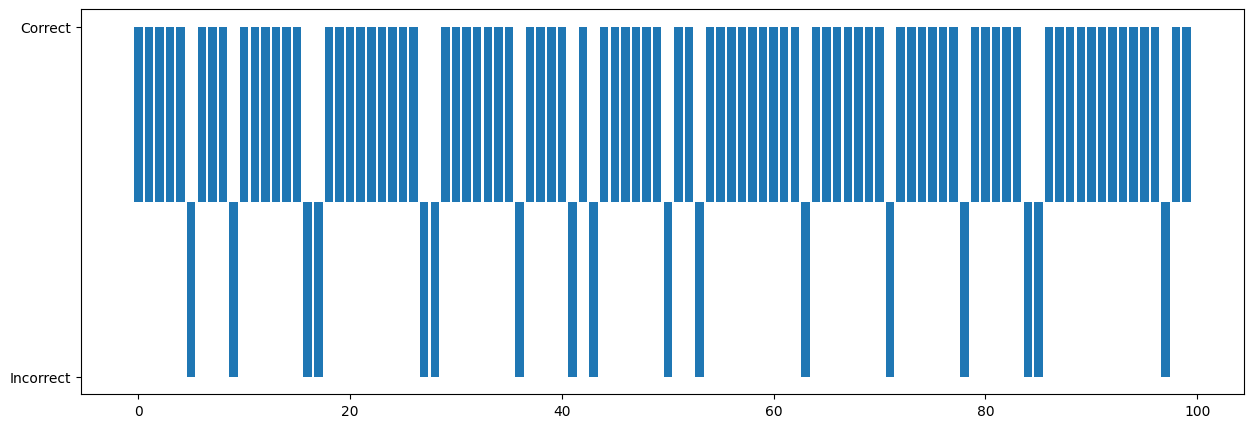

#Aqua PHI

In [ ]:
from datasets import load_dataset
import json, re
dataset = load_dataset("aqua_rat")

Generating train split:   0%|          | 0/97467 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/254 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/254 [00:00<?, ? examples/s]

In [ ]:
def my_test():
  with (open("/content/drive/MyDrive/Aqua_Log/Phi/COTPhi_Result.txt", "w") as f,
    open("/content/drive/MyDrive/Aqua_Log/Phi/COTPhi_Answer.txt", "w") as d):

    f.write("Chain of Thought Prompting: \n")
    d.write("Chain of Thought Prompting: \n")
    s, e = 0, 99
    correct = 0
    for i, batch in enumerate(dataset["test"]): # Change debug_dataloader to train_dataloader or dev_dataloader when necessary
      if i < s:
        continue
      if(i > e):
        break
      question = batch['question']
      options = ''
      for o in batch['options']:
        options = options + " " + o
      #prompt = f"{question} \n {options} \n Take a deep breath and work on this problem step-by-step."
      #prompt = f"{question} \n {options} \n Explain this problem to me in at least 200 words. Then solve for the answer."
      #prompt = f"{question}\n{options}\n"
      #prompt = f"{question} Explain this problem to me in at least 200 words. Then solve for the answer."
      #prompt = f"{question} Take a deep breath and work on this problem step-by-step."
      #prompt = question
      #prompt = question_analysis_prompt_few_shot + "\n" + "Q: " + question
      #prompt = QAP_COT_Combination + "\n" + "Q: " + question
      prompt = chain_of_thought_aqua + question
      true_answer = batch['correct']
      inputs = tokenizer(prompt, return_tensors="pt")
      inputs = inputs.to("cuda")
      outputs = model.generate(**inputs, max_new_tokens=350, do_sample=False) # You may need to modify max_new_tokens
      answer_line = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
      answer_line = extract_last_answer(answer_line)
      our_answer = re.findall("the correct answer is ([A|B|C|D|E])", answer_line,re.IGNORECASE)
      if our_answer == []:
        our_answer = "[]"
      else:
        our_answer = our_answer[0]
      d.write(f"Question[{i}]:\n {question}\n")
      d.write(f"Correct answer:\n {true_answer}\n")
      d.write(f"Full answer:\n {answer_line}\n")
      d.write(f"Our answer:\n {our_answer}\n")
      d.write("-"*100+"\n")
      if our_answer and our_answer == true_answer:
        correct += 1
        f.write(f"{i} Correct \n")
        print(f"{i} Correct")
      else:
        f.write(f"{i} Incorrect \n")
        print(f"{i} Incorrect")
      d.flush()
      f.flush()

    score = (correct/(i))*100
    print(score)
    f.write(f"Score: {score}")
my_test()

0 Incorrect
1 Incorrect
2 Incorrect
3 Incorrect
4 Incorrect
5 Incorrect
6 Incorrect
7 Incorrect
8 Incorrect
9 Incorrect
10 Incorrect
11 Incorrect
12 Incorrect
13 Incorrect
14 Incorrect
15 Incorrect
16 Correct
17 Incorrect
18 Incorrect
19 Incorrect
20 Incorrect
21 Incorrect
22 Incorrect
23 Incorrect
24 Incorrect
25 Incorrect
26 Incorrect
27 Correct
28 Incorrect
29 Incorrect
30 Incorrect
31 Correct
32 Incorrect
33 Incorrect
34 Incorrect
35 Incorrect
36 Incorrect
37 Correct
38 Incorrect
39 Incorrect
40 Incorrect
41 Incorrect
42 Incorrect
43 Correct
44 Incorrect
45 Incorrect
46 Incorrect
47 Incorrect
48 Incorrect
49 Incorrect
50 Incorrect
51 Incorrect
52 Incorrect
53 Incorrect
54 Incorrect
55 Incorrect
56 Correct
57 Incorrect
58 Incorrect
59 Incorrect
60 Incorrect
61 Incorrect
62 Incorrect
63 Incorrect
64 Incorrect
65 Incorrect
66 Incorrect
67 Incorrect
68 Correct
69 Incorrect
70 Incorrect
71 Incorrect
72 Incorrect
73 Incorrect
74 Incorrect
75 Incorrect
76 Incorrect
77 Incorrect
78 Incorre

In [ ]:
!python --version

Python 3.10.12
